# Часть 1. Проверка гипотезы в Python и составление аналитической записки

- Автор: Сковородина Ю. А.
- Дата: 24.05.2025

**Цель:**
Провести исследовательский анализ данных пользователей Яндекс Книги и оценить результаты A/B-тестирования в BitMotion Kit для проверки гипотез и принятия решений на основе статистических выводов.


## 1. Загрузка данных и знакомство с ними

In [1]:
# Импорт стандартных библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт внешних библиотек
from scipy import stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower

In [2]:
# Загрузка данных
yandex_data = pd.read_csv('/datasets/yandex_knigi_data.csv')

# Выводим первые строки датафрейма на экран
yandex_data.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [3]:
# Выводим информацию о датафрейме
yandex_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


In [4]:
# Количество уникальных пользователей (puid)
unique_users = yandex_data['puid'].nunique()
print(f"Количество уникальных пользователей: {unique_users}")

Количество уникальных пользователей: 8540


Количество уникальных пользователей — 8540 из 8784 записей, что указывает на наличие дубликатов в данных. Теперь перейдём к их проверке.

In [5]:
# Поиск дубликатов по идентификатору пользователя
puid_duplicates = yandex_data[yandex_data.duplicated(subset=['puid'])]
print(f"Количество дубликатов: {len(puid_duplicates)}")

Количество дубликатов: 244


In [6]:
# Удаляем дубликаты
yandex_data = yandex_data.drop_duplicates(subset='puid')

In [7]:
# Проверим размерность датафрейма после удаления дубликатов
yandex_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8540 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8540 non-null   int64  
 1   city        8540 non-null   object 
 2   puid        8540 non-null   int64  
 3   hours       8540 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 333.6+ KB


В ходе загрузки данных выявлено 8784 записи с 8540 уникальными пользователями, что указало на наличие дубликатов - 244 записи. Полные дубликаты были успешно удалены, итоговый объём данных составил 8540 строк. Данные готовы для дальнейшего анализа.

In [8]:
# Разделяем выборки на Москву и Санкт-Петербург
moscow = yandex_data.query("city == 'Москва'")['hours']
spb = yandex_data.query("city == 'Санкт-Петербург'")['hours']

# Выводим описательную статистику по времени активности для двух городов
print("Статистика по времени активности (в часах) для Москвы:")
print(moscow.describe())

print("\nСтатистика по времени активности (в часах) для Санкт-Петербурга:")
print(spb.describe())

Статистика по времени активности (в часах) для Москвы:
count    6234.000000
mean       10.881092
std        36.851683
min         0.000018
25%         0.059903
50%         0.924498
75%         5.939972
max       857.209373
Name: hours, dtype: float64

Статистика по времени активности (в часах) для Санкт-Петербурга:
count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64


- Проверим, сколько пользователей в каждой группе:

In [9]:
# Смотрим количество пользователей в двух городах
print("Количество пользователей в выборках:")
print(yandex_data['city'].value_counts())

Количество пользователей в выборках:
Москва             6234
Санкт-Петербург    2306
Name: city, dtype: int64


- Покажем распределение времени активности пользователей в двух городах на графике

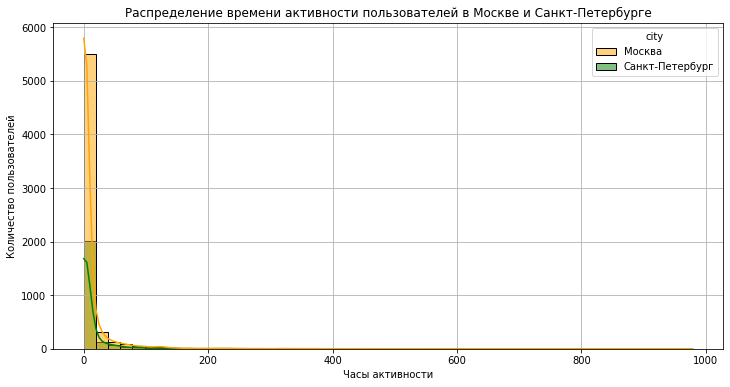

In [10]:
# Сгруппируем данные
cities_data = yandex_data[yandex_data['city'].isin(['Москва', 'Санкт-Петербург'])]

# Визуализация распределений
plt.figure(figsize=(12, 6))
sns.histplot(data=cities_data, x='hours', hue='city', bins=50, kde=True, palette={'Москва': 'orange', 'Санкт-Петербург': 'green'})
plt.title('Распределение времени активности пользователей в Москве и Санкт-Петербурге')
plt.xlabel('Часы активности')
plt.ylabel('Количество пользователей')
plt.grid(True)

plt.show()

Глядя на распределение времени активности пользователей на графике, можно заметить сильную асимметрию — большинство пользователей проводят мало времени в приложении, но есть выбросы с высокими значениями. Для проверки гипотезы используем t-тест Стьюдента.

In [11]:
# Сформулируем гипотезы:
# H₀: среднее время активности пользователей в Москве и Санкт-Петербурге одинаково.
# H₁: пользователи из Санкт-Петербурга проводят в среднем больше времени в приложении, чем пользователи из Москвы.

# Применяем односторонний t-тест Стьюдента
t_stat, p_value = ttest_ind(spb, moscow, alternative='greater')

# Фиксируем уровень значимости
alpha = 0.05

# Результат статистического теста
print(f"p-value: {p_value}")

if p_value < alpha:
    print("\nРезультат статистически значим: пользователи из Санкт-Петербурга действительно проводят больше времени в приложении, чем из Москвы.")
else:
    print("\nНет статистически значимых различий между Москвой и Санкт-Петербургом.")

p-value: 0.338193679651558

Нет статистически значимых различий между Москвой и Санкт-Петербургом.


Результаты показывают, что гипотеза о большей активности пользователей из Санкт-Петербурга не подтвердилась. Различия в поведении пользователей между двумя городами незначимы, и мы можем считать поведение пользователей из Москвы и Санкт-Петербурга сопоставимым по времени активности.

## 3. Аналитическая записка




**Тип теста и уровень значимости:**
Так как мы сравнивали два города — Москву и Санкт-Петербург — и хотели понять, проводят ли пользователи из Питера больше времени в приложении, применили односторонний t-тест Стьюдента, несмотря на асимметрию в распределении. Уровень значимости — 0.05.

**Результаты:**
p-value = 0.338

**Вывод:**
Так как p-value выше порогового значения, нулевая гипотеза не отвергается. Это означает, что статистически значимых различий в среднем времени активности между пользователями из Москвы и Санкт-Петербурга не выявлено.

**Возможные объяснения:**

- Пользователи в обоих городах могут иметь схожие привычки потребления цифрового контента.

- Дополнительные факторы вроде маркетинговых кампаний, интерфейса или одинаковых рекомендаций внутри приложения могут нивелировать влияние региона.

# Часть 2. Анализ результатов A/B-теста BitMotion Kit

В данном разделе проводится анализ A/B-тестирования нового интерфейса BitMotion Kit.

**Цель исследования**: Оценить, влияет ли новый интерфейс сайта BitMotion Kit на увеличение доли зарегистрированных пользователей, совершивших покупку в течение 7 дней после регистрации.

In [12]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)


In [13]:
# Выводим информацию о таблице participants
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [14]:
# Выводим первые строки таблицы с участниками
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [15]:
# Выводим первые строки таблицы с событиями
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [16]:
# Выводим информацию о таблице events
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [17]:
# Количество уникальных пользователей в participants
unique_users = participants['user_id'].nunique()
print(f"Количество уникальных пользователей: {unique_users}")

Количество уникальных пользователей: 13638


In [18]:
# Поиск дубликатов по user_id
duplicates = participants[participants.duplicated(subset='user_id')]
print(f"Количество дубликатов: {len(duplicates)}")

Количество дубликатов: 887


In [19]:
# Удаление дубликатов
participants = participants.drop_duplicates(subset='user_id')

# Проверим размерность таблицы после удаления дубликатов
participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13638 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13638 non-null  object
 1   group    13638 non-null  object
 2   ab_test  13638 non-null  object
 3   device   13638 non-null  object
dtypes: object(4)
memory usage: 532.7+ KB


В данных об участниках содержалось 14 525 записей, но только 13 638 уникальных пользователей — обнаружено и удалено 887 дубликатов. В таблице событий пропуски присутствуют только в столбце `details`, что обусловлено тем, что дополнительная информация указывается не для всех типов событий. Данные готовы для дальнейшего анализа.

## Анализ активности пользователей в тесте

In [20]:
# Посмотрим распределение пользователей по тестам и группам
group_counts = participants.groupby(['ab_test', 'group'])['user_id'].nunique().reset_index()
group_counts.columns = ['test_name', 'group', 'unique_users']
display(group_counts)

,test_name,group,unique_users
0,interface_eu_test,A,5174
1,interface_eu_test,B,5229
2,recommender_system_test,A,2421
3,recommender_system_test,B,814


In [21]:
# Проверим пользователей, попавших сразу в несколько тестов
multi_test_users = participants.groupby('user_id')['ab_test'].nunique()
cross_test_count = (multi_test_users > 1).sum()
print(f'Пользователей, участвующих в нескольких тестах: {cross_test_count}')


Пользователей, участвующих в нескольких тестах: 0


In [22]:
# Проверим, есть ли пользователи в двух группах одного теста
multi_group_users = participants.groupby(['user_id', 'ab_test'])['group'].nunique()
cross_group_count = (multi_group_users > 1).sum()
print(f'Пользователей, попавших в обе группы одного теста: {cross_group_count}')

Пользователей, попавших в обе группы одного теста: 0


In [23]:
# Общая оценка количества пользователей в группах A и B (по всем тестам вместе)
overall_group_counts = participants.groupby('group')['user_id'].nunique()
display(overall_group_counts)

group
A    7595
B    6043
Name: user_id, dtype: int64

**Вывод о корректности теста:**

Проверка показала, что пользователи не пересекаются между тестами и не попадают в обе группы одного теста, что подтверждает техническую корректность сплитования. Для дальнейшего анализа были выбраны группы А и В теста interface_eu_test, поскольку они имеют сбалансированное количество участников (5174 и 5229). Данные по тесту recommender_system_test были исключены из-за сильного дисбаланса групп.

In [24]:
# Пользователи, участвующие в тесте interface_eu_test
test_users = participants[participants['ab_test'] == 'interface_eu_test']['user_id']

# Все события этих пользователей
test_events = events[events['user_id'].isin(test_users)]

test_users = participants[participants['ab_test'] == 'interface_eu_test']['user_id'].unique()
print(f"Всего пользователей в тесте: {len(test_users)}")

test_events = events[events['user_id'].isin(test_users)]
print(f"Всего событий пользователей теста: {len(test_events)}")

Всего пользователей в тесте: 10403
Всего событий пользователей теста: 76658


In [25]:
# Получаем дату регистрации каждого пользователя
registrations = test_events[test_events['event_name'] == 'registration']
reg_dates = registrations.groupby('user_id')['event_dt'].min().reset_index()
reg_dates.columns = ['user_id', 'registration_date']

# Объединяем с событиями
events_with_reg = test_events.merge(reg_dates, on='user_id', how='left')

# Считаем дни с момента регистрации
events_with_reg['days_since_reg'] = (events_with_reg['event_dt'] - events_with_reg['registration_date']).dt.days

# Оставляем события, совершённые в первые 7 дней
events_7d = events_with_reg[events_with_reg['days_since_reg'] < 7]

users_7d = events_7d['user_id'].nunique()
print(f"Пользователей с событиями в первые 7 дней: {users_7d}")

Пользователей с событиями в первые 7 дней: 10403


In [26]:
from statsmodels.stats.power import NormalIndPower

# Заданные параметры
baseline_conversion = 0.30  # базовый показатель конверсии
effect_size_absolute = 0.03  # минимальное ожидаемое изменение (3%)
alpha = 0.05  # уровень значимости 5% (достоверность 95%)
power = 0.8  # мощность теста

# Относительный размер эффекта
effect_size_relative = effect_size_absolute / baseline_conversion

# Расчёт необходимого размера выборки для каждой группы
analysis = NormalIndPower()
required_sample_size = analysis.solve_power(
    effect_size=effect_size_relative,
    alpha=alpha,
    power=power,
    alternative='two-sided'
)

print(f"Необходимое количество пользователей в каждой группе: {int(required_sample_size)}")

Необходимое количество пользователей в каждой группе: 1569


In [27]:
# Объединяем данные
events_7d = events_7d.merge(participants, on='user_id', how='left')

# Уникальные пользователи по группам
users_by_group = events_7d.groupby('group')['user_id'].nunique()

# Покупатели по группам
buyers_by_group = events_7d[events_7d['event_name'] == 'purchase'].groupby('group')['user_id'].nunique()

# Создаём таблицу с конверсией
conversion = pd.DataFrame({
    'users': users_by_group,
    'buyers': buyers_by_group
}).fillna(0).astype(int)

conversion['cr'] = (conversion['buyers'] / conversion['users']).round(3)

print(conversion)

       users  buyers     cr
group                      
A       5174    1427  0.276
B       5229    1532  0.293


In [28]:
# Разность конверсий
lift = conversion.loc['B', 'cr'] - conversion.loc['A', 'cr']
print(f"Прирост конверсии в тестовой группе: {lift:.3f}")

Прирост конверсии в тестовой группе: 0.017


В группе B уровень конверсии составил 29.3%, что выше, чем в группе A — 27.6%. Разница между ними составляет 1.7%. Количество пользователей в обеих группах примерно одинаково (около 5200 человек), что обеспечивает сопоставимость результатов.

По предварительным наблюдениям, тестовая группа проявила более высокую активность в части совершения покупок. Это может указывать на то, что новый интерфейс положительно повлиял на поведение пользователей. Однако поскольку прирост конверсии не достигает заранее установленного минимального эффекта в 3%, необходимо дополнительно проверить статистическую значимость разницы, прежде чем делать окончательные выводы.

In [29]:
# Данные по группам
n_A = 5174  # Размер выборки A
n_B = 5229  # Размер выборки B

x_A = 1427  # Кол-во успешных событий в группе A
x_B = 1532  # Кол-во успешных событий в группе B

# Ставим группу B первой, так как хотим проверить улучшение метрики
count = np.array([x_B, x_A])
nobs = np.array([n_B, n_A])

# Односторонний z-тест: проверка на прирост
z_stat, p_value = proportions_ztest(count=count, nobs=nobs, alternative='larger')

print(f"Z-статистика: {z_stat:.3f}")
print(f"P-значение: {p_value:.4f}")

alpha = 0.05

if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Количество пользователей, совершающих покупку, статистически значимо увеличивается после внедрения новой версии сайта.")
else:
    print("Нет оснований отвергнуть нулевую гипотезу. Влияние новой версии сайта на поведение пользователей статистически не подтверждено.")

Z-статистика: 1.942
P-значение: 0.0261
Отвергаем нулевую гипотезу. Количество пользователей, совершающих покупку, статистически значимо увеличивается после внедрения новой версии сайта.
